# Machine Learning Techniques for Data-Driven Models of Commercial Buildings

This tutorial shows the use of common machine learning models and techniques for forecasting the energy consumption in a rooftop unit (RTU). This example uses real-world trend data from a BAS. As with many existing systems this is an older HVAC system that has some operational faults. This example shows how to use ML to conduct a short-term forecast (1-3 days) given a few months of training data and 1-2 weeks of historical data as an input.

The purpose of this example is to demonstrate basic methods and strategies. Model accuracy will increase with additional ML pipeline steps, such as detailed feature engineering and hyperparameter tuning.

# Import Packages

The first step in running machine learning experiments is installing external Python packages. There are many open-source packages for data science and machine learning that are commonly used and assist with data manipulation, plotting, and modeling. The following command loads the popular Pandas and Matplotlib packages.

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Data

Most ML packages in Python utilize Pandas data frames for handling data. The first step is to import the time series data into a data frame. In this case, interval data from a BAS is being loaded into a data frame from a CSV. The data is resample to 15 minutes, to ensure all of the data is on a consistent interval frequency. This step is evaluated based on each individual data set.

In [53]:
n_int_per_hour = 4
resample_int = '15T'

# Read a pandas DataFrame
df = pd.read_csv("RTU_BAS_Trends.csv", delimiter=",", index_col=0)
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None) # Remove time zone from datetime index
df = df.resample(resample_int).mean()

df.head()

,DHI,DNI,OATmp,ZnT,ZnT Occ Htg Sp,ZnT Clg Sp Eff,ZnT Htg Sp Eff,Htg Stage 1,SF Sts,Htg Stage 2,Clg Stage 1,Clg Stage 2,Occ Sched Cmd,Total Power,hour_of_day,day_of_week,Clg Stages,Htg Stages
2024-04-18 00:00:00,0.0,0.0,47.716667,72.020000,69.0,85.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.320566,0.0,3.0,0.0,0.0
2024-04-18 00:15:00,0.0,0.0,46.866667,71.823335,69.0,85.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.320854,0.0,3.0,0.0,0.0
2024-04-18 00:30:00,0.0,0.0,46.016667,71.563333,69.0,85.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321176,0.0,3.0,0.0,0.0
2024-04-18 00:45:00,0.0,0.0,45.166667,71.500000,69.0,85.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321131,0.0,3.0,0.0,0.0
2024-04-18 01:00:00,0.0,0.0,44.575000,71.500000,69.0,85.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.320251,1.0,3.0,0.0,0.0


## Initial Visualization

The first step of any time series ML project is to plot the target and key covariate parameters. This allows quickly determining whether there are issues with data ranges, missing data, etc.

Text(0, 0.5, 'Electric Power (kW)')

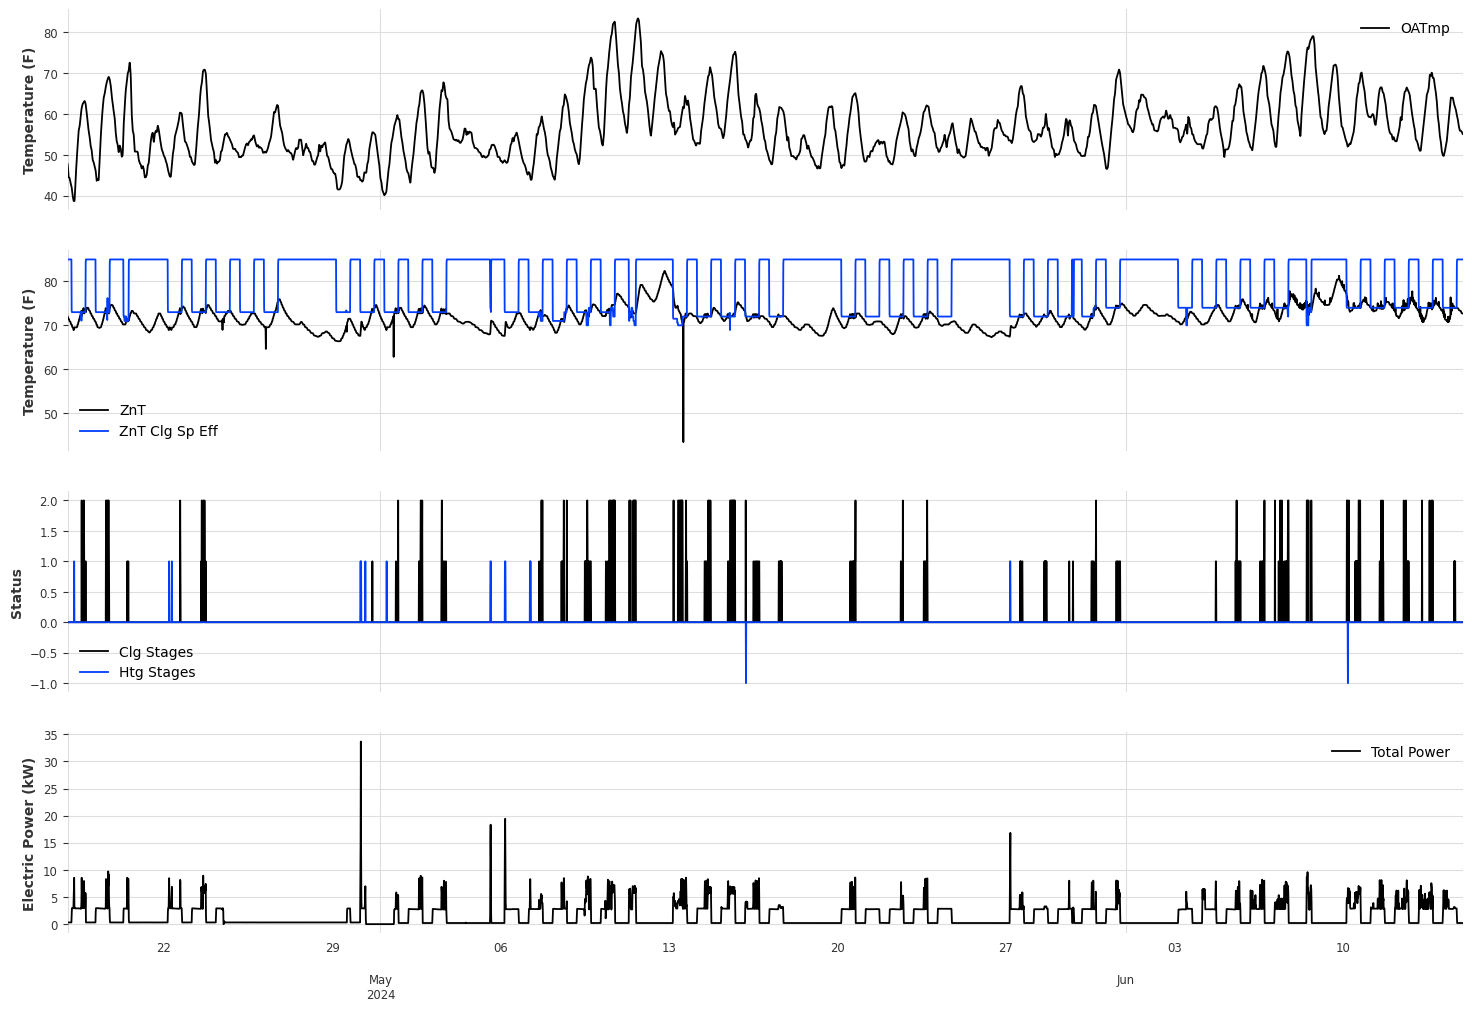

In [42]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(18,12))

df.loc[:, ['OATmp']].plot(ax=axes[0])
axes[0].set_ylabel("Temperature (F)")

df.loc[:, ['ZnT', 'ZnT Clg Sp Eff']].plot(ax=axes[1])
axes[1].set_ylabel("Temperature (F)")

df.loc[:, ['Clg Stages', 'Htg Stages']].plot(ax=axes[2])
axes[2].set_ylabel("Status")

df.loc[:, ['Total Power']].plot(ax=axes[3])
axes[3].set_ylabel("Electric Power (kW)")



# Determine Cooling Days

It is also useful to visualize other data, such as the daily statistics like maximum outdoor air temperature and electric power. This provides insight into whether the training data contain conditions, such as cooling mode operation, that we are trying to predict in the test data.

Text(0, 0.5, 'Electric Power (kW)')

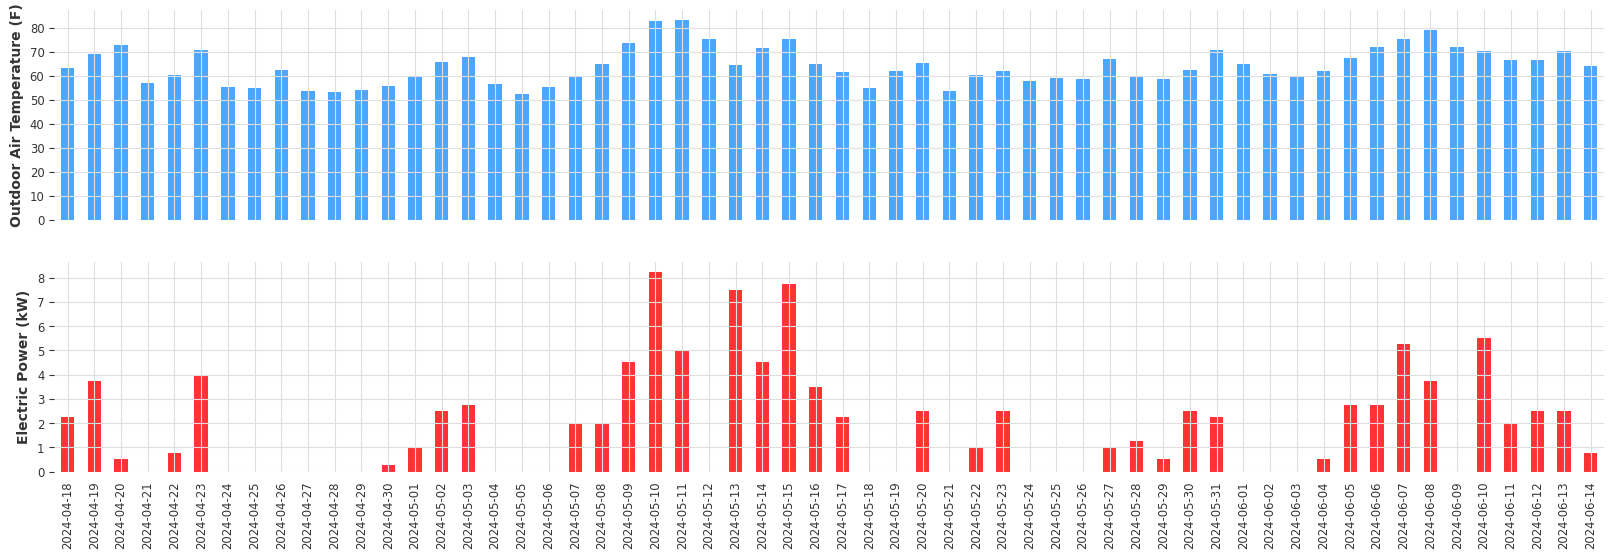

In [43]:
dates = np.unique(df.sort_index().index.date)
data_freq_hr = df.index.freq.nanos/(60*60*10**9)

# Outdoor Air
daily_max_oa_tmp = df.loc[:, 'OATmp'].groupby(df.index.date).max()

# Cooling Stages
clg_stage_hours = df.loc[:, 'Clg Stages'].groupby(df.index.date).sum()*data_freq_hr

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 6))

daily_max_oa_tmp.plot.bar(ax=axes[0], color='dodgerblue', alpha=0.8)
clg_stage_hours.plot.bar(ax=axes[1], color='red', alpha=0.8)

axes[0].set_ylabel("Outdoor Air Temperature (F)")
axes[1].set_ylabel("Electric Power (kW)")

# Model Inputs

This cell defines any global inputs that are used across the entire ML project. 

The prediction horizon is defined as 1 day.  The parameter, n_pred, is defined as the number of intervals per hour (4) times 24 hours times 1 day.

In [8]:
# Prediction intervals
n_pred = n_int_per_hour*24*1

The target is the time series that is predicted by the model. In this case the Total Power column in the DataFrame is being predicted. This is the instantaneous electric power consumption from the energy meter in kW.

In [45]:
target_name = 'Total Power'

# Data Engineering

## Create Target Series

The target name defined in the Model Inputs section is used to get the time series from the input DataFrame matching the defined name (Total Power). The target is plotted for initial evaluation. Notice there are some anomalous data points in the target time series.

<AxesSubplot: >

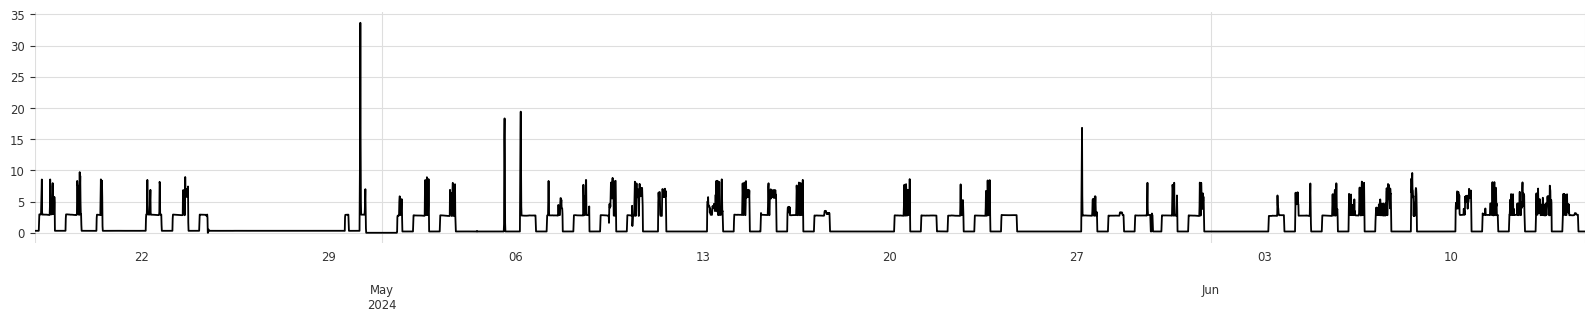

In [46]:
target = df.loc[:, target_name]
target.plot(figsize=(20, 3))

## Create Training Data

For ML we need to split the data into training and test data. There are a number of ways of doing this (splitting based on fraction, rolling interval splitting for cross-validation, etc.). I'm splitting the data based on the date (6/1/2024).

In [47]:
# Set up training data sets

training_start = df.index[0]
training_end = datetime.datetime(2024, 6, 1) + datetime.timedelta(days=1) - datetime.timedelta(hours=0.25)
#train_df = df.loc[:training_end, :]

print(training_start)
print(training_end)
#train_df.tail()

2024-04-18 00:00:00
2024-06-01 23:45:00


## Create Test Data

The test data is created by splitting the data on a desired prediction date (6/12/2024) considering the previous data needed for inputs to the models. In practice, model evaluation would utilize techniques like cross-validation or backtesting that evaluate the prediction errors across many prediction days. Only a single day is shown in this example. A key point in the train/test split is that the test data should not contain any data used in the training process.

In [48]:
# Set up test data sets

test_end = datetime.datetime(2024, 6, 12) + datetime.timedelta(days=1) - datetime.timedelta(hours=0.25)
test_start = test_end - datetime.timedelta(days=14)

print(test_start)
print(test_end)

2024-05-29 23:45:00
2024-06-12 23:45:00


## Create TimeSeries Objects

The ML models work with specific time series data objects. This code converts from Pandas DataFrame to Darts Time Series objects.

In [49]:
from darts import TimeSeries

# Create training and test time series object for the target
train_target = TimeSeries.from_series(target.loc[training_start:training_end])
test_target = TimeSeries.from_series(target.loc[test_start:test_end])

# Get the lagged series that is provided to the test series prediction
test_lag_target = test_target[:-n_pred]

# Feature Engineering

Another key step is determining additional features in the model.

In [50]:
# Create a time series object for the DataFrame
series = TimeSeries.from_dataframe(df)

In [51]:
# Create past covariate and future covariate time series objects
past_cov = series[['OATmp', 'DHI', 'DNI', 'ZnT', 'Htg Stage 1', 'Htg Stage 2', 'Clg Stage 1', 'Clg Stage 2']]
future_cov = series[['day_of_week', 'hour_of_day', 'SF Sts', 'Occ Sched Cmd', 'ZnT Clg Sp Eff', 'ZnT Htg Sp Eff']]

# Visualize Data

This cell plots the predicted date June 12, 2024 that is being predicted in the test data with other relevant covariates.

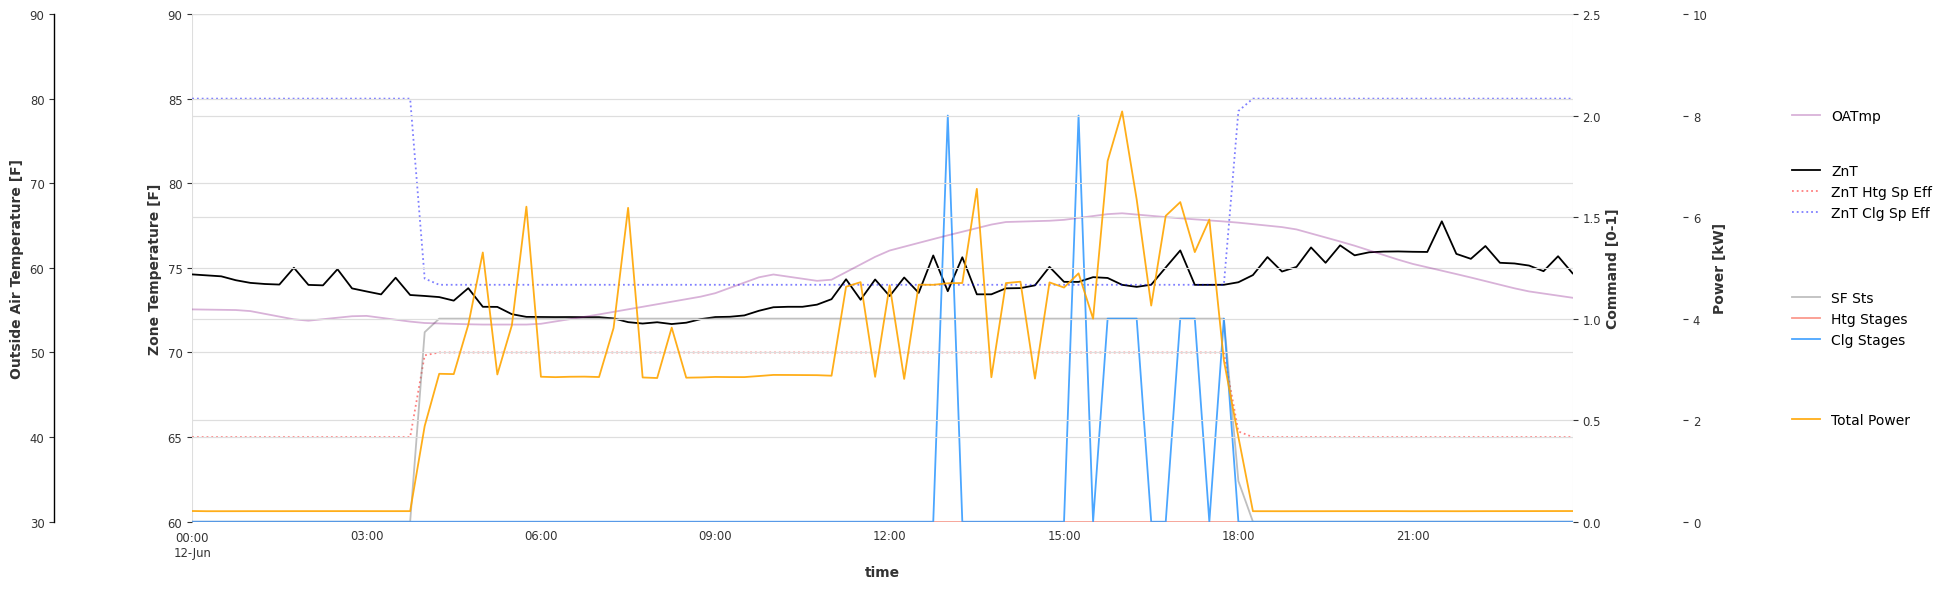

In [52]:
plot_date = f'2024-06-12'
plot_df = df.copy().loc[plot_date, :]
plot_target = target.copy().loc[plot_date]

fig, axes = plt.subplots(figsize=(20, 6))
ax1 = axes
ax2 = axes.twinx()
ax3 = axes.twinx()
ax4 = axes.twinx()

plot_df.plot(y=['OATmp'], ax=ax3, color='purple', alpha=0.3)
plot_df.plot(y=['ZnT'], ax=ax1, color='black')
plot_df.plot(y=['ZnT Htg Sp Eff'], ax=ax1, color='red', alpha=0.5, linestyle=':')
plot_df.plot(y=['ZnT Clg Sp Eff'], ax=ax1, color='blue', alpha=0.5, linestyle=':')
plot_df.plot(y=['SF Sts'], ax=ax2, color='gray', alpha=0.5) #, linestyle='--')
plot_df.plot(y=['Htg Stages'], ax=ax2, color='salmon', alpha=0.8)
plot_df.plot(y=['Clg Stages'], ax=ax2, color='dodgerblue', alpha=0.8)
plot_target.plot(y=['Total Power'], ax=ax4, color='orange', alpha=0.9)

ax3.legend(bbox_to_anchor=(1.15, 0.8), loc='center left')
ax1.legend(bbox_to_anchor=(1.15, 0.65), loc='center left')
ax2.legend(bbox_to_anchor=(1.15, 0.4), loc='center left')
ax4.legend(bbox_to_anchor=(1.15, 0.2), loc='center left')

ax1.set_ylabel('Zone Temperature [F]')
ax3.set_ylabel('Outside Air Temperature [F]')
ax2.set_ylabel('Command [0-1]')
ax4.set_ylabel('Power [kW]')

ax1.set_ylim([60, 90])
ax3.set_ylim([30, 90])
ax2.set_ylim([0, 2.5])
ax4.set_ylim([0, 10])

ax3.spines.left.set_position(("axes", -0.1))
ax3.spines["left"].set_visible(True)
ax3.yaxis.set_label_position('left')
ax3.yaxis.set_ticks_position('left')
ax4.spines.right.set_position(("axes", 1.08))

#plt.title(f'{plot_start_datetime}')
plt.tight_layout()

# Hyperparameter Tuning

A critical aspect of modeling with machine learning is determining model hyperparameters. These may be identified through intuition, experimentation, etc. For this demonstration I'll provide parameters, but parameters are typically determined through a set of experiments called hyperparameter optimization. Each model has a unique set of hyperparameters that need to be optimized. Prediction performance varies greatly depending on the selected hyperparameters.

## Regression Model Hyperparameters

In [17]:
# Used to reduce the number of features by considering intervals in the lag series
n_lag_int = 1 # interval in the lag series [hr]

# Lags of the Target - Previous values of the target that are used as inputs to the model
n_lag_days = 10
n_lags = [-x*n_int_per_hour*n_lag_int for x in range(1,int(24/n_lag_int)*n_lag_days+1)]

# Past Covariates - Lagged features that are measured, but not known during the forecast horizon
n_lag_past_covariates_days = 5
n_lags_past_covariates = [-x*n_int_per_hour*n_lag_int for x in range(1,int(24/n_lag_int)*n_lag_past_covariates_days+1)]

# Future Covariates - Features that are known during the prediction horizon
n_lag_future_covariates_days = 5
n_lags_future_covariates = [-x*n_int_per_hour*n_lag_int for x in range(1,int(24/n_lag_int)*n_lag_future_covariates_days+1)]

# Print these values for reference
print(n_lags)
print(n_lags_past_covariates)
print(n_lags_future_covariates)

[-4, -8, -12, -16, -20, -24, -28, -32, -36, -40, -44, -48, -52, -56, -60, -64, -68, -72, -76, -80, -84, -88, -92, -96, -100, -104, -108, -112, -116, -120, -124, -128, -132, -136, -140, -144, -148, -152, -156, -160, -164, -168, -172, -176, -180, -184, -188, -192, -196, -200, -204, -208, -212, -216, -220, -224, -228, -232, -236, -240, -244, -248, -252, -256, -260, -264, -268, -272, -276, -280, -284, -288, -292, -296, -300, -304, -308, -312, -316, -320, -324, -328, -332, -336, -340, -344, -348, -352, -356, -360, -364, -368, -372, -376, -380, -384, -388, -392, -396, -400, -404, -408, -412, -416, -420, -424, -428, -432, -436, -440, -444, -448, -452, -456, -460, -464, -468, -472, -476, -480, -484, -488, -492, -496, -500, -504, -508, -512, -516, -520, -524, -528, -532, -536, -540, -544, -548, -552, -556, -560, -564, -568, -572, -576, -580, -584, -588, -592, -596, -600, -604, -608, -612, -616, -620, -624, -628, -632, -636, -640, -644, -648, -652, -656, -660, -664, -668, -672, -676, -680, -684,

# Fit and Predict with Models

## Baseline Model

### Exponential Smoothing

It is common to always use a baseline model for model comparison. The objective is to ensure that any complex ML model is able to provide a better prediction than a simple statistical models. An exponential smoothing model with a daily seasonal period is used. 

In [18]:
from darts.models import ExponentialSmoothing

es_model = ExponentialSmoothing(seasonal_periods=n_int_per_hour*24)
es_model.fit(test_lag_target)
es_pred = es_model.predict(n=n_pred)

/root/venv/lib/python3.10/site-packages/statsforecast/core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Regression Models

The regression class of models has been demonstrated to often perform well in literature, and is generally easy to train. This class of models also includes popular gradient-boosted machines (GBM). Two popular versions

### LightGBM

The first GBM model that is evaluated is LightGBM (https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf). This model is useful as it trains quickly and generally provides accurate results for many time series forecasting problems.

In [20]:
from darts.models import LightGBMModel

lgbm_model = LightGBMModel(
    lags=n_lags,
    lags_past_covariates=n_lags_past_covariates,
    lags_future_covariates=n_lags_future_covariates,
    output_chunk_length=n_pred,
    verbose=-1
)
lgbm_model.fit(train_target, past_covariates=past_cov, future_covariates=future_cov)
lgbm_pred = lgbm_model.predict(n=n_pred, series=test_lag_target, past_covariates=past_cov, future_covariates=future_cov)

### XGBoost

A second GBM model, XGBoost, is used for comparison. This model leverages many decision trees to increase accuracy, but training cost is increased and is less interpretable than other decision tree models.

In [21]:
from darts.models import XGBModel

xgb_model = XGBModel(
    lags=n_lags,
    lags_past_covariates=n_lags_past_covariates,
    lags_future_covariates=n_lags_future_covariates,
    output_chunk_length=n_pred
)
xgb_model.fit(train_target, past_covariates=past_cov, future_covariates=future_cov)
xgb_pred = xgb_model.predict(n=n_pred, series=test_lag_target, past_covariates=past_cov, future_covariates=future_cov)

## Deep Learning Models

### N-Beats

Next we try a deep learning model. The N-BEATS (https://arxiv.org/abs/1905.10437) model is newer deep learning time series forecasting model. It is primarily focused on the temporal aspects, so many not perform as well when trying to predict time series with significant influences from exogenous variables.

In [22]:
from darts.models import NBEATSModel

nbeats_model = NBEATSModel(
    input_chunk_length=n_int_per_hour*24,
    output_chunk_length=n_int_per_hour*24,
    n_epochs=100,
    )

nbeats_model.fit(train_target, past_covariates=past_cov)
nbeats_pred = nbeats_model.predict(n=n_pred, series=test_lag_target, past_covariates=past_cov)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 13.0 M | train
-------------------------------------------------------------
12.9 M    Trainable params
6.5 K     Non-trainable params
13.0 M    Total params
51.810    Total estimated model params size (MB)
Epoch 99: 100%|██████████| 130/130 [00:19<00:00,  6.68it/s, train_loss=0.966]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<

### TSMixer

Finally we try TSMixer (https://arxiv.org/abs/2303.06053). This model attempts to take advantage of the performance of linear temporal models, while still enabling the use of cross-variate data. This is accomplished by stacking multi-layer perceptrons (MLP) for time mixing and feature mixing components.

In [23]:
from darts.models import TSMixerModel

tsmixer_model = TSMixerModel(
    input_chunk_length=n_int_per_hour*24,
    output_chunk_length=n_int_per_hour*24,
    hidden_size=512,
    ff_size=512,
    n_epochs=100,
    )

tsmixer_model.fit(train_target, past_covariates=past_cov, future_covariates=future_cov)
tsmixer_pred = tsmixer_model.predict(n=n_pred, series=test_lag_target, past_covariates=past_cov, future_covariates=future_cov)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear           | 9.3 K  | train
6 | feature_mixing_hist   | _FeatureMixing   | 377 K  | train
7 | feature_mixing_future | _FeatureMixing   | 368 K  | train
8 | conditional_mixer     | ModuleList       | 2.3 M  | train
9 | fc_out                | Linear           | 513    | train
-------------------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     To

# Model Evaluation

After all models are trained we evaluate the accuracy of each model in predicting the test data. Model evaluation may be conducted qualitatively, but ultimately quantitive methods are preferred.

## Plot All Models

A simple way of viewing the accuracy is plotting the prediction for each model against the actual data.

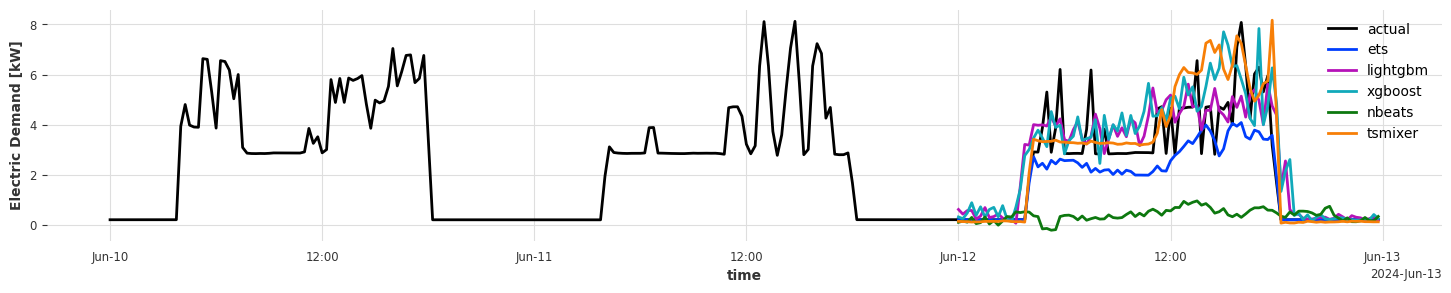

In [38]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(18, 3))
test_target[-n_int_per_hour*24*3:].plot(label='actual', ax=ax)
es_pred.plot(label="ets", ax=ax)
lgbm_pred.plot(label='lightgbm', ax=ax)
xgb_pred.plot(label="xgboost", ax=ax)
nbeats_pred.plot(label="nbeats", ax=ax)
tsmixer_pred.plot(label="tsmixer", ax=ax)
ax.set_ylabel('Electric Demand [kW]')
plt.legend()

## Error Metrics

Quantitative metrics are commonly used for model evaluation. These metrics may be used in hyperparameter optimization routines, which seek to minimize prediction errors. Some common metrics are RMSE, MAE, MAPE, sMAPE. The following table shows the various metrics for each model.

In [33]:
from darts.metrics.metrics import coefficient_of_variation, rmse, mae, mape, smape

actual = test_target[-n_int_per_hour*24*1:]
model_preds = [es_pred, lgbm_pred, xgb_pred, nbeats_pred, tsmixer_pred]
actuals = [actual for x in range(0, len(model_preds))]


pd.DataFrame(
    {
        'RMSE': rmse(actuals, model_preds), 
        'COV': coefficient_of_variation(actuals, model_preds),
        'MAPE': mape(actuals, model_preds), 
        'sMAPE': smape(actuals, model_preds), 
        'MAE': mae(actuals, model_preds), 
    }, index=['ets', 'lgbm', 'xgboost', 'nbeats', 'tsmixer']
)

,RMSE,COV,MAPE,sMAPE,MAE
ets,1.284967,52.324473,17.681407,21.534259,0.781954
lgbm,1.100671,44.819818,82.839318,38.973633,0.762536
xgboost,1.289530,52.510271,96.520516,42.555014,0.924307
nbeats,2.934580,119.497449,85.364000,118.738302,2.173400
tsmixer,1.192226,48.547988,33.933276,34.758070,0.688165


## Plot Best Performing Models

The top two performing models are plotted for comparison.

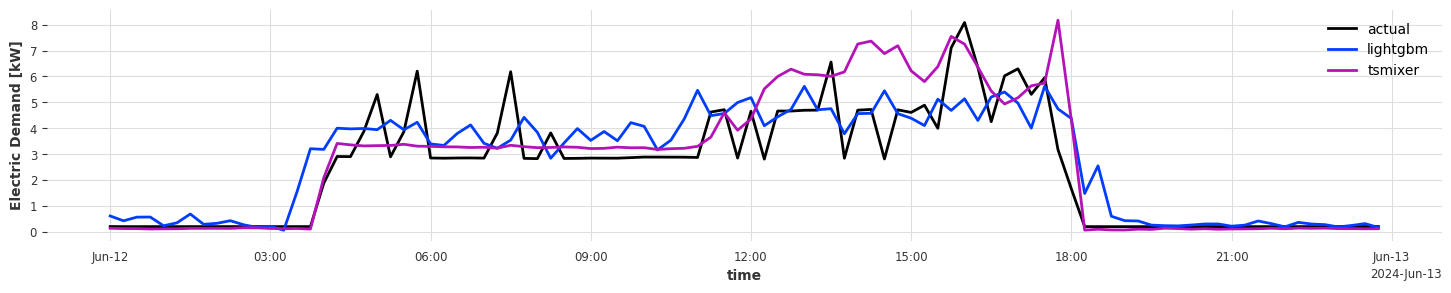

In [37]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(18, 3))
test_target[-n_int_per_hour*24*1:].plot(label='actual', ax=ax)
lgbm_pred.plot(label='lightgbm', ax=ax)
tsmixer_pred.plot(label="tsmixer", ax=ax)
ax.set_ylabel('Electric Demand [kW]')
plt.legend()

# What's Next?

Topics that weren't covered in much detail, but that are very important:

- Data Pre-processing and Cleaning: Prior to modeling, it is necessary to deal with missing data, resampling at different frequency, normalizing or transforming data. Some models may be more or less sensitive to this step and require different techniques.

- Feature Engineering: Evaluating which parameters influence the prediction of the target prevents over- or under-fitting a model. This is especially critical in modeling the influence of dynamic systems, such as the influence of HVAC system control on energy consumption.

- Hyperparameter Tuning: Similar to Feature Engineering it is important to determine the model hyperparameters that provide the best fit. The tradeoff of many hyperparameters is often in model training cost or convergence. This is often automated using a hyperparameter optimization library. If doing extensive hyperparameter optimization then data should be split into an additional validation set, specifically for this process.